In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
import os
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
from torchvision import datasets
from torch.utils.data import ConcatDataset, DataLoader
import os

old_train_path = "/kaggle/input/cataract-image-dataset/processed_images/train"
test_path = "/kaggle/input/cataract-image-dataset/processed_images/test"

immature_path = "/kaggle/input/cataract-photo-image-dataset/Dataset/train/Immature"
mature_path = "/kaggle/input/cataract-photo-image-dataset/Dataset/train/Mature"
normal_train_path = "/kaggle/input/cataract-photo-image-dataset/Dataset/train/Normal"
normal_test_path = "/kaggle/input/cataract-photo-image-dataset/Dataset/test/Normal"
normal_valid_path = "/kaggle/input/cataract-photo-image-dataset/Dataset/valid/Normal"

In [ ]:

os.makedirs("/kaggle/working/combined_train/cataract", exist_ok=True)
os.makedirs("/kaggle/working/combined_train/normal", exist_ok=True)

# Copy all cataract images
!cp /kaggle/input/cataract-image-dataset/processed_images/train/cataract/* /kaggle/working/combined_train/cataract/
!cp $immature_path/* /kaggle/working/combined_train/cataract/
!cp $mature_path/* /kaggle/working/combined_train/cataract/

# Copy all normal images
!cp /kaggle/input/cataract-image-dataset/processed_images/train/normal/* /kaggle/working/combined_train/normal/
!cp $normal_train_path/* /kaggle/working/combined_train/normal/
!cp $normal_test_path/* /kaggle/working/combined_train/normal/
!cp $normal_valid_path/* /kaggle/working/combined_train/normal/

In [ ]:
combined_train_path = "/kaggle/working/combined_train"

train_dataset = datasets.ImageFolder(combined_train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_transform)

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=2)

print("Classes found:", test_dataset.classes)

Classes found: ['cataract', 'normal']


In [ ]:
import timm
import torch.nn as nn

model = timm.create_model('efficientnet_b3', pretrained=True)

for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2) 
)

model.to(device)

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [12]:
def evaluate(model, loader):
    model.eval()
    correct, total_loss = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            total_loss += loss.item() * images.size(0)
    avg_loss = total_loss / len(loader.dataset)
    acc = 100 * correct / len(loader.dataset)
    return acc, avg_loss


In [13]:
def train_model(model, epochs):
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        train_acc = 100 * correct / total
        train_loss = total_loss / total

        val_acc, val_loss = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Train Loss: {train_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

In [ ]:
#  GradScaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train_model(model, epochs=10)

#Fine-tune 
for name, param in model.named_parameters():
    if any(f"blocks.{i}" in name for i in range(12, 17)) or "classifier" in name:
        param.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

train_model(model, epochs=5)


/tmp/ipykernel_35/2932876058.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_35/2853662641.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10 | Train Acc: 85.36% | Train Loss: 0.4310 | Val Acc: 90.91% | Val Loss: 0.3551
Epoch 2/10 | Train Acc: 91.45% | Train Loss: 0.3489 | Val Acc: 94.18% | Val Loss: 0.3087
Epoch 3/10 | Train Acc: 93.77% | Train Loss: 0.3223 | Val Acc: 95.45% | Val Loss: 0.3011
Epoch 4/10 | Train Acc: 94.50% | Train Loss: 0.3078 | Val Acc: 96.73% | Val Loss: 0.2760
Epoch 5/10 | Train Acc: 95.68% | Train Loss: 0.3004 | Val Acc: 96.00% | Val Loss: 0.2847
Epoch 6/10 | Train Acc: 94.95% | Train Loss: 0.3006 | Val Acc: 96.73% | Val Loss: 0.2774
Epoch 7/10 | Train Acc: 95.55% | Train Loss: 0.2894 | Val Acc: 96.91% | Val Loss: 0.2714
Epoch 8/10 | Train Acc: 95.82% | Train Loss: 0.2916 | Val Acc: 97.82% | Val Loss: 0.2682
Epoch 9/10 | Train Acc: 96.05% | Train Loss: 0.2875 | Val Acc: 96.91% | Val Loss: 0.2617
Epoch 10/10 | Train Acc: 95.91% | Train Loss: 0.2910 | Val Acc: 96.91% | Val Loss: 0.2721
Epoch 1/5 | Train Acc: 96.32% | Train Loss: 0.2836 | Val Acc: 97.27% | Val Loss: 0.2732
Epoch 2/5 | Train Acc

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
test_acc, test_loss = evaluate(model, test_loader)
print(f"\n Final Test Accuracy after fine-tuning: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")



 Final Test Accuracy after fine-tuning: 94.21% | Test Loss: 0.3564


In [ ]:
from PIL import Image
import os
import torch

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

import torch.nn.functional as F

def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = val_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_label = idx_to_class[pred_idx]
        confidence = probs[0][pred_idx].item()

    return pred_label, confidence


test_folder = '/kaggle/input/mycataractdataset2'

for img_file in os.listdir(test_folder):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(test_folder, img_file)
        pred_label, confidence = predict_image(image_path)
        print(f" {img_file} → Prediction: {pred_label} (Confidence: {confidence:.2f})")

 C4.jpeg → Prediction: normal (Confidence: 0.90)
 N5.jpg → Prediction: cataract (Confidence: 0.59)
 C1.jpeg → Prediction: cataract (Confidence: 0.76)
 N1.jpeg → Prediction: normal (Confidence: 0.55)
 N3.jpg → Prediction: normal (Confidence: 0.74)
 C3.png → Prediction: cataract (Confidence: 0.90)
 N4.jpg → Prediction: normal (Confidence: 0.85)
 C2.jpeg → Prediction: cataract (Confidence: 0.63)
 N2.jpeg → Prediction: normal (Confidence: 0.62)


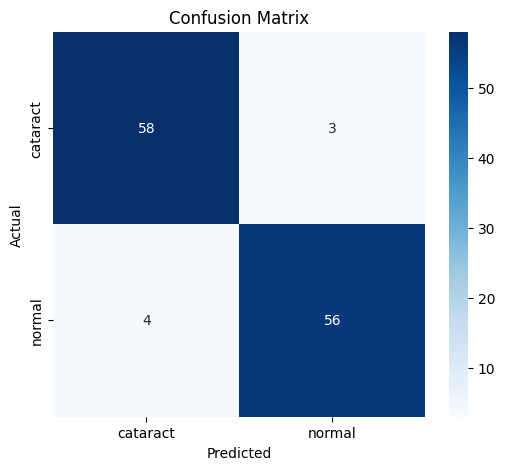


 Classification Report:
              precision    recall  f1-score   support

    cataract       0.94      0.95      0.94        61
      normal       0.95      0.93      0.94        60

    accuracy                           0.94       121
   macro avg       0.94      0.94      0.94       121
weighted avg       0.94      0.94      0.94       121



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def get_preds_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

y_pred, y_true = get_preds_and_labels(model, test_loader)

cm = confusion_matrix(y_true, y_pred)
class_names = test_dataset.classes 

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
